## НТ3

### Задание
Преоразовать существующий код для распознавания последовательности рукописных символов в текст.
Написать генератор произвольной последовательности рукописных символов.

ГЕНЕРАЦИЯ НАБОРА ДАННЫХ

Сгенерировать набор текстовых строк из допустимых символов.
Каждому набору поставить в соотвествие массив изоражений соответствующих символов.
Добавить пробелы для разделения слов, символы пробелов не использовать во время классификации.

КЛАССИФИКАЦИЯ (k ближайших соседей)

Часть символов оставить для обучения классификатора. Остальные  классифицировать
по аналогии с примером mnist с прошлого занятия. Т.е. преобразовывать изображение в вектор.
Выбрать оптимальный классификатор в зависимости от k- количество соседей.
Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

РАСПОЗНАВАНИЕ

Итак, к данному этапу Вы из массива изображений "восстановили" текст.
Случайно удалите некоторые символы,и случайно добавьте символы в результат распознавания.
Рассчитайте метрику CER.

In [95]:
import random
from PIL import Image
import cv2
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import editdistance
import matplotlib.pyplot as plt

### Выведем все знаки из файла

In [96]:
path_dir = 'data'
name = os.listdir(path_dir)
if 'times' in name:
    name[name.index('times')] = '*'
print(name)

['(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'h', 't', '*', 'w', 'X', 'y']


### Сгенерируем набор текстовых строк из допустимых символов
У нас будет 10 строк по 10 символов

In [97]:
def random_strings(char_list, string_length, num_strings):
    result = []
    random.seed(0)
    for _ in range(num_strings):
        random_string = ''.join(random.choice(char_list) for _ in range(string_length))
        result.append(random_string)
    return result
char_list = name
strings = random_strings(char_list, string_length=10, num_strings=10)
print(strings)

['78)3th74h6', 'w1t-4-,X3*', 'X-4,+5h*,6', '85Xy1*h9t3', ')*(+7y(Xh5', '25+1w22-*9', '++5th,4*4,', '*5*1X*w49+', 'X75w24010)', 'X3h++--)+*']


### Каждому набору поставим в соотвествие массив изоражений соответствующих символов. Добавим пробелы для разделения слов.

In [98]:
def get_image_paths_for_strings(strings, root_dir):
    image_paths = {}

    for s in strings:
        image_paths[s] = []
        for char in s:
            if char == '*': char = 'times'
            folder_path = os.path.join(root_dir, char)
            if os.path.exists(folder_path):
                images = os.listdir(folder_path)
                if images:
                    chosen_image = random.choice(images)
                    full_image_path = os.path.join(folder_path, chosen_image)
                    image_paths[s].append(full_image_path)

    return image_paths

In [99]:
def create_combined_image(symbol_paths, output_path, img_size=(45, 45), padding=15, border=10):
    total_width = img_size[0] * len(symbol_paths) + padding * (len(symbol_paths) - 1) + 2 * border
    total_height = img_size[1] + 2 * border

    combined_image = Image.new("RGB", (total_width, total_height), color=(255, 255, 255))

    x_offset = border
    for path in symbol_paths:
        symbol_img = Image.open(path)
        combined_image.paste(symbol_img, (x_offset, border))
        x_offset += img_size[0] + padding

    combined_image.save(output_path)
    print(f"Изображение сохранено в дирректории: {output_path}")

In [100]:
result = get_image_paths_for_strings(strings, path_dir)
my_images_paths = {}


output_dir = "out"
os.makedirs(output_dir, exist_ok=True)


for string, paths in result.items():
    _string = string.replace('*', '[times]')
    output_path = os.path.join(output_dir, f"{_string}_image.png")
    create_combined_image(paths, output_path)  # Создание изображения
    my_images_paths[string] = output_path  # Сохраняем путь


print("Готовые пути к изображениям:", my_images_paths)

Изображение сохранено в дирректории: out\78)3th74h6_image.png
Изображение сохранено в дирректории: out\w1t-4-,X3[times]_image.png
Изображение сохранено в дирректории: out\X-4,+5h[times],6_image.png
Изображение сохранено в дирректории: out\85Xy1[times]h9t3_image.png
Изображение сохранено в дирректории: out\)[times](+7y(Xh5_image.png
Изображение сохранено в дирректории: out\25+1w22-[times]9_image.png
Изображение сохранено в дирректории: out\++5th,4[times]4,_image.png
Изображение сохранено в дирректории: out\[times]5[times]1X[times]w49+_image.png
Изображение сохранено в дирректории: out\X75w24010)_image.png
Изображение сохранено в дирректории: out\X3h++--)+[times]_image.png
Готовые пути к изображениям: {'78)3th74h6': 'out\\78)3th74h6_image.png', 'w1t-4-,X3*': 'out\\w1t-4-,X3[times]_image.png', 'X-4,+5h*,6': 'out\\X-4,+5h[times],6_image.png', '85Xy1*h9t3': 'out\\85Xy1[times]h9t3_image.png', ')*(+7y(Xh5': 'out\\)[times](+7y(Xh5_image.png', '25+1w22-*9': 'out\\25+1w22-[times]9_image.png', '+

## Классификация

In [101]:
def get_cv_image(image):
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    else:
        image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    return image

def get_vector(image):
    image = get_cv_image(image)

    _, thresh = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        return cv2.resize(image[y:y+h, x:x+w], (45, 45)).flatten()

    return None

In [102]:
x = []
y = []

def process_label_images(label, img_paths):
    vectors = [get_vector(path) for path in img_paths]
    labels = [label] * len(vectors)
    return vectors, labels

with ThreadPoolExecutor() as executor:
    results = list(executor.map(lambda item: process_label_images(*item), result.items()))

for vectors, labels in results:
    x.extend(vectors)
    y.extend(labels)

x = np.array(x, dtype=np.float32)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

param_grid = {'n_neighbors': range(1, 11)}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=4)
grid_search.fit(x_train, y_train)

best_k = grid_search.best_params_['n_neighbors']
print(f"Лучшее значение k: {best_k}")

Лучшее значение k: 7


In [103]:
def create_and_write_model(path_file, k):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(x_train, y_train)
    with open(path_file, 'wb') as file:
        pickle.dump(knn_model, file)

def read_model(path_file):
    with open(path_file, 'rb') as file:
        knn_model_loaded = pickle.load(file)
    return knn_model_loaded

In [104]:
model_path = 'knn_model.pkl'

create_and_write_model(model_path, best_k)
knn_model = read_model(model_path)
predictions = knn_model.predict(x_test)

print(f'accuracy = {accuracy_score(y_test, predictions)}')

accuracy = 0.1


In [105]:
def merge_two_rects(rect1, rect2):
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    x = min(x1, x2)
    y = min(y1, y2)
    w = max(x1 + w1, x2 + w2) - x
    h = max(y1 + h1, y2 + h2) - y
    return (x, y, w, h)

def calculate_distance(rect1, rect2):
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    center1 = (x1 + w1 / 2, y1 + h1 / 2)
    center2 = (x2 + w2 / 2, y2 + h2 / 2)
    return ((center1[0] - center2[0]) ** 2 + (center1[1] - center2[1]) ** 2) ** 0.5

def merge_close_rectangles(rects, distance_threshold, count_limit):
    while len(rects) > count_limit:
        pairs_to_merge = [
            (rects[i], rects[j])
            for i in range(len(rects))
            for j in range(i + 1, len(rects))
            if calculate_distance(rects[i], rects[j]) < distance_threshold
        ]

        if not pairs_to_merge: break  # Если нет пар для объединения, выходим из цикла

        rect1, rect2 = pairs_to_merge[0]
        merged_rect = merge_two_rects(rect1, rect2)
        rects.remove(rect1)
        rects.remove(rect2)
        rects.append(merged_rect)

    return rects

def merge_rectangles(rects, distance_threshold = 25, count_limit = 10):
    rects = merge_close_rectangles(rects, distance_threshold, count_limit)

    if len(rects) > count_limit:
        rects = sorted(rects, key=lambda rect: (rect[2] * rect[3]), reverse=True)
        big_rects = rects[:count_limit]
        other_rects = rects[count_limit:]

        for rect in other_rects:
            closest_big_rect = min(big_rects, key=lambda big: calculate_distance(rect, big))
            merged_rect = merge_two_rects(rect, closest_big_rect)
            big_rects[big_rects.index(closest_big_rect)] = merged_rect

        return big_rects

    return rects

def extract_symbols(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)[1]

    dilated = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))
    rects = [cv2.boundingRect(c) for c in cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]]

    if len(rects) > 10:
        rects = merge_rectangles(rects)

    rects.sort(key=lambda r: r[0])

    symbols = [get_vector(image[y:y+h, x:x+w]) for (x, y, w, h) in rects]

    for (x, y, w, h) in rects:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 1)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

    return symbols

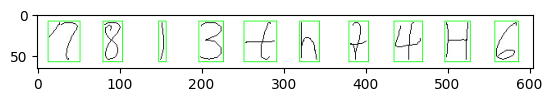

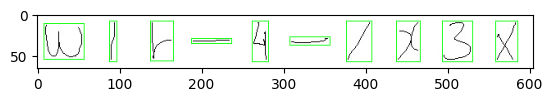

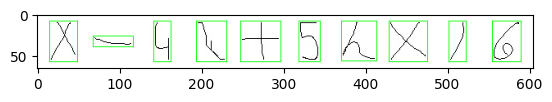

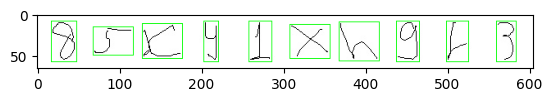

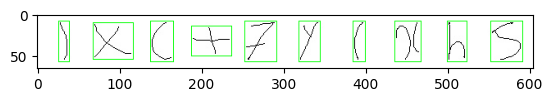

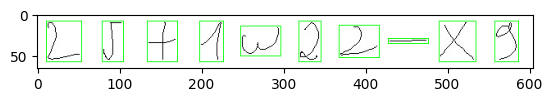

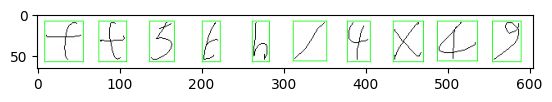

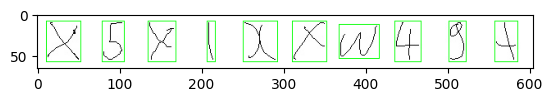

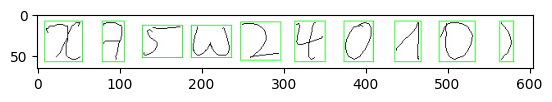

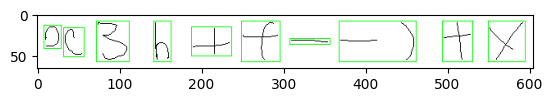

In [106]:
results = []
symb_vectors = []

for string, img_path in my_images_paths.items():
    symb_images = extract_symbols(img_path)
    predictions = knn_model.predict(symb_images)
    accuracy = accuracy_score(list(string), list(predictions[0]))
    results.append((string, predictions[0], accuracy))

In [107]:
from pandas import DataFrame, concat

df_results = DataFrame(results, columns=['Исходные символы', 'Предсказанные символы', 'Accuracy'])
mean_accuracy = df_results['Accuracy'].mean()

new_row = DataFrame({
    'Предсказанные символы': ['Средняя accuracy'],
    'Accuracy': [mean_accuracy]
})

df_result = concat([df_results, new_row], ignore_index=True)
df_result

,Исходные символы,Предсказанные символы,Accuracy
0,78)3th74h6,"++5th,4*4,",0.00
1,"w1t-4-,X3*","w1t-4-,X3*",1.00
2,"X-4,+5h*,6","X-4,+5h*,6",1.00
3,85Xy1*h9t3,85Xy1*h9t3,1.00
4,)*(+7y(Xh5,)*(+7y(Xh5,1.00
5,25+1w22-*9,"X-4,+5h*,6",0.00
6,"++5th,4*4,","++5th,4*4,",1.00
7,*5*1X*w49+,"X-4,+5h*,6",0.00
8,X75w24010),X3h++--)+*,0.10
9,X3h++--)+*,X3h++--)+*,1.00


## CER

In [108]:
def modify_and_calculate_cer(row):
    original = list(row['Исходные символы'])
    predicted = list(row['Предсказанные символы'])

    num_to_modify = random.randint(1, 3)
    indices = random.sample(range(len(predicted)), num_to_modify)
    predicted = [predicted[i] for i in range(len(predicted)) if i not in indices]
    symbols = [x[0].split('\\')[-1] for x in os.walk(path_dir)][1:]
    predicted += random.choices(symbols, k=num_to_modify)

    cer = editdistance.eval(''.join(original), ''.join(predicted)) / max(len(original), len(predicted) or 1)
    return ''.join(original), ''.join(predicted), cer

In [109]:
df_results[['Исходные символы', 'Предсказанные символы', 'CER']] = df_results.apply(modify_and_calculate_cer, axis=1, result_type='expand')

mean_cer = df_results['CER'].mean()

new_row = DataFrame({
    'Исходные символы': [''],
    'Предсказанные символы': ['Среднее значение'],
    'CER': [mean_cer]
})

df_сer = concat([df_results, new_row], ignore_index=True).drop(columns=['Accuracy'])
df_сer

,Исходные символы,Предсказанные символы,CER
0,78)3th74h6,"++th,4*4,times",1.30
1,"w1t-4-,X3*","w1t--,X*+X",0.40
2,"X-4,+5h*,6","-,+5h,61ww",0.60
3,85Xy1*h9t3,85Xy19t3times0,0.80
4,)*(+7y(Xh5,(+7y(h52)1,0.60
5,25+1w22-*9,"X-4,+5h,62",1.00
6,"++5th,4*4,","++th4*4,93",0.40
7,*5*1X*w49+,"4,+5h*,689",0.90
8,X75w24010),X3h+--)+*-,0.90
9,X3h++--)+*,X3h++-)+(w,0.30
